# Comparing international cities for their similarities and differences
This notebook explores the similarities and differences of three international cities, New York, London, and Seoul according to their similarities and differences.

In [1]:
import pandas as pd
import numpy as np
import os
import geocoder
import folium
import requests
import json
import html5lib 
from pandas import json_normalize
from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3
from geopy.distance import distance
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup as bs
from itertools import chain

# pd.set_option('display.max_rows', None)

## Acquiring and cleaning the data
### Neighborhood data
First we acquire the neighborhood and district data for London from Wikipedia.  
As the data contains invisible characters in the column headers as well as columns that can make life difficult, we immediately remove them

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_areas_of_London"
df_london = pd.read_html(url, header=0)[1]
columns=[]
for i in df_london.columns:
    columns.append(' '.join(i.split()))
df_london.columns = columns
for i in df_london.columns:
    df_london[i].str.split().str.join(' ')
df_london

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728
...,...,...,...,...,...,...
528,Woolwich,Greenwich,LONDON,SE18,020,TQ435795
529,Worcester Park,"Sutton, Kingston upon Thames",WORCESTER PARK,KT4,020,TQ225655
530,Wormwood Scrubs,Hammersmith and Fulham,LONDON,W12,020,TQ225815
531,Yeading,Hillingdon,HAYES,UB4,020,TQ115825


We can see in the output that there are also neighborhoods that belong to different post towns, so we only take the ones from London.

In [3]:
df_london = df_london[df_london['Post town'].str.contains('LONDON')].reset_index(drop=True)
df_london

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Aldgate,City[10],LONDON,EC3,020,TQ334813
3,Aldwych,Westminster[10],LONDON,WC2,020,TQ307810
4,Anerley,Bromley[11],LONDON,SE20,020,TQ345695
...,...,...,...,...,...,...
305,Woodford,Redbridge,LONDON,"IG8, E18",020,TQ405915
306,Woodford Green,"Redbridge, Waltham Forest","LONDON, WOODFORD GREEN",IG8,020,TQ405915
307,Woodside Park,Barnet,LONDON,N12,020,TQ256925
308,Woolwich,Greenwich,LONDON,SE18,020,TQ435795


In the complete output we can see a few problems. First, some of the boroughs have references from Wikipedia included, so we remove them. Second, some of the neighborhoods have alternate names in brackets, which would cause trouble later on when we found to find information for them. We manually adjust them as well as the entry for *Somerstown* which should be *Somers Town*. We also replace all *ands* in the boroughs through a comma.

In [4]:
df_london = df_london.drop(columns=['Post town', 'Dial code', 'OS grid ref', 'Postcode district'])
df_london.rename(columns={'London borough': 'Borough', 'Location': 'Neighborhood'},inplace=True)
df_london["Borough"] = df_london["Borough"].map(lambda x: x.strip('0123456789[]'))
df_london.at[df_london.index[df_london['Neighborhood'].str.contains('Bexleyheath')], 'Neighborhood'] = 'Bexleyheath'
df_london.at[df_london.index[df_london['Neighborhood'].str.contains('Bromley')], 'Neighborhood'] = 'Bromley'
df_london.at[df_london.index[df_london['Neighborhood'].str.contains('Marylebone')], 'Neighborhood'] = 'Marylebone'
df_london.at[df_london.index[df_london['Neighborhood'].str.contains('Sydenham')], 'Neighborhood'] = 'Sydenham'
df_london.at[df_london.index[df_london['Neighborhood'].str.contains('Somerstown')], 'Neighborhood'] = 'Somers Town'
df_london['Borough'] = df_london['Borough'].str.replace(' and ', ', ')
df_london

,Neighborhood,Borough
0,Abbey Wood,"Bexley, Greenwich"
1,Acton,"Ealing, Hammersmith, Fulham"
2,Aldgate,City
3,Aldwych,Westminster
4,Anerley,Bromley
...,...,...
305,Woodford,Redbridge
306,Woodford Green,"Redbridge, Waltham Forest"
307,Woodside Park,Barnet
308,Woolwich,Greenwich


We define a function that gets us the coordinates for each neighborhood or None if there are no coordinates.

In [5]:
def get_coords(neighborhood, city, borough=None):
    address = neighborhood + ', ' + city
    if borough:
        address = neighborhood + ', ' + borough + ', ' + city
    geolocator = Nominatim(user_agent="mult_loc")
    location = geolocator.geocode(address)
    try:
        latitude = location.latitude
        longitude = location.longitude
    except:
        latitude = None
        longitude = None
    return latitude, longitude

Now we can get the coordinates for each neighborhood. Or in the case we already did that, we can just load the file. For London, we only check for the neighborhood as many neighborhoods have several boroughs to which they belong to. As London does have neighborhoods with the same name, we use the borough for those in the request.

In [6]:
if os.path.isfile('london_data.csv'):
    df_london = pd.read_csv('london_data.csv', index_col=0)
else:
    latitudes = []
    longitudes = []
    for neighbor, borough in zip(df_london['Neighborhood'], df_london['Borough']):
        latitude, longitude = get_coords(neighbor, 'London', borough)
        latitudes.append(latitude)
        longitudes.append(longitude)
    df_london['Latitude'] = latitudes
    df_london['Longitude'] = longitudes

We can see that several neighborhoods did not get an address.

In [7]:
df_tmp = df_london[df_london.isnull().any(axis=1)]
df_tmp

,Neighborhood,Borough,Latitude,Longitude


We will correct this by using the Google API instead of the OpenStreetMap API. So first we define the function and load the key.

In [8]:
def get_coords_google(api_key, neighborhood, city, borough=None):
    address = neighborhood + ', ' + city
    if borough:
        address = neighborhood + ', ' + borough + ', ' + city
    geolocator = GoogleV3(api_key=google_api, user_agent="mult_loc")
    location = geolocator.geocode(address)
    try:
        latitude = location.latitude
        longitude = location.longitude
    except:
        latitude = None
        longitude = None
    return latitude, longitude

In [9]:
google_api = open('google_api','r').read()

And then we search the neighborhoods.

In [10]:
for neighbor, borough in zip(df_tmp['Neighborhood'], df_tmp['Borough']):
    latitude, longitude = get_coords_google(google_api, 'Brompton', 'London', 'Kensington, ChelseaHammersmith, Fulham')
    df_london.at[df_london.index[df_london['Neighborhood'].str.contains(neighbor)], 'Latitude'] = latitude
    df_london.at[df_london.index[df_london['Neighborhood'].str.contains(neighbor)], 'Longitude'] = longitude

And we have values for all neighborhoods.

In [11]:
df_tmp = df_london[df_london.isnull().any(axis=1)]
df_tmp

,Neighborhood,Borough,Latitude,Longitude


Let's do a small sanity check and see if any of the coordinates is further than 30km away from the core of London.

In [12]:
address = 'London, London'
geolocator = Nominatim(user_agent="mult_loc")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
coord = (latitude, longitude)

for lat, lng, borough, neighborhood in zip(df_london['Latitude'], df_london['Longitude'], df_london['Borough'], df_london['Neighborhood']):
    if distance(coord, (lat, lng)).km >= 30:
        print(neighborhood, borough, lat, lng, distance(coord, (lat, lng)))

Dartford Dartford 51.45124929999999 0.2998333 30.346058536766783 km


There is one value close above 30km, but this is acceptable.

In [13]:
df_london

,Neighborhood,Borough,Latitude,Longitude
0,Abbey Wood,"Bexley, Greenwich",51.485572,0.119687
1,Acton,"Ealing, Hammersmith, Fulham",51.502729,-0.254255
2,Aldgate,City,51.514248,-0.075719
3,Aldwych,Westminster,51.513103,-0.114920
4,Anerley,Bromley,51.407599,-0.061939
...,...,...,...,...
305,Woodford,Redbridge,51.606806,0.034012
306,Woodford Green,"Redbridge, Waltham Forest",51.483494,-0.196802
307,Woodside Park,Barnet,51.617948,-0.185579
308,Woolwich,Greenwich,51.482670,0.062334


Afterwards we save the dataframe to csv so that we can load it the next time to reduce the API calls for the location provided.

In [14]:
df_london.to_csv('london_data.csv')

Now we can do the same for New York and Seoul. We start with New York.

In [15]:
url = "https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City"
df_newyork = pd.read_html(url, header=0)[0]
df_newyork

,Community Board(CB),Areakm2,Pop.Census2010,Pop./km2,Neighborhoods
0,Bronx CB 1,7.17,91497,12761,"Melrose, Mott Haven, Port Morris"
1,Bronx CB 2,5.54,52246,9792,"Hunts Point, Longwood"
2,Bronx CB 3,4.07,79762,19598,"Claremont, Concourse Village, Crotona Park, Mo..."
3,Bronx CB 4,5.28,146441,27735,"Concourse, Highbridge"
4,Bronx CB 5,3.55,128200,36145,"Fordham, Morris Heights, Mount Hope, Universit..."
5,Bronx CB 6,4.01,83268,20765,"Bathgate, Belmont, East Tremont, West Farms"
6,Bronx CB 7,4.84,139286,28778,"Bedford Park, Norwood, University Heights"
7,Bronx CB 8,8.83,101731,11521,"Fieldston, Kingsbridge, Kingsbridge Heights, M..."
8,Bronx CB 9,12.41,172298,13884,"Bronx River, Bruckner, Castle Hill, Clason Poi..."
9,Bronx CB 10,16.76,120392,7183,"City Island, Co-op City, Locust Point, Pelham ..."


We define a custom split that gives us only the community board/borough.

In [16]:
def custom_newyork_split(line):
    return line.split('CB')[0]

We can see that the last row includes a summary which we do not need an which we can drop. We also rename and drop columns that are not needed.

In [17]:
df_newyork.drop(df_newyork.tail(1).index,inplace=True)
df_newyork.drop(columns=['Areakm2','Pop.Census2010','Pop./km2'],inplace=True)
df_newyork.rename(columns={'Community Board(CB)': 'Borough', 'Neighborhoods': 'Neighborhood'},inplace=True)
df_newyork['Borough'] = df_newyork['Borough'].apply(custom_newyork_split)
df_newyork

,Borough,Neighborhood
0,Bronx,"Melrose, Mott Haven, Port Morris"
1,Bronx,"Hunts Point, Longwood"
2,Bronx,"Claremont, Concourse Village, Crotona Park, Mo..."
3,Bronx,"Concourse, Highbridge"
4,Bronx,"Fordham, Morris Heights, Mount Hope, Universit..."
5,Bronx,"Bathgate, Belmont, East Tremont, West Farms"
6,Bronx,"Bedford Park, Norwood, University Heights"
7,Bronx,"Fieldston, Kingsbridge, Kingsbridge Heights, M..."
8,Bronx,"Bronx River, Bruckner, Castle Hill, Clason Poi..."
9,Bronx,"City Island, Co-op City, Locust Point, Pelham ..."


And as a next step, we split the neighborhoods into single rows by replicating the borough row for each occurrence of neighbor in the list of neighbors.

In [18]:
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

In [19]:
lens = df_newyork['Neighborhood'].str.split(',').map(len)
df_newyork = pd.DataFrame({'Borough': np.repeat(df_newyork['Borough'], lens), 'Neighborhood': chainer(df_newyork['Neighborhood'])}).reset_index(drop=True)
df_newyork

,Borough,Neighborhood
0,Bronx,Melrose
1,Bronx,Mott Haven
2,Bronx,Port Morris
3,Bronx,Hunts Point
4,Bronx,Longwood
...,...,...
325,Staten Island,Prince's Bay
326,Staten Island,Richmond Valley
327,Staten Island,Rossville
328,Staten Island,Tottenville


Now we can get all the coordinates again.

In [20]:
if os.path.isfile('newyork_data.csv'):
    df_newyork = pd.read_csv('newyork_data.csv', index_col=0)
else:
    latitudes = []
    longitudes = []
    for borough, neighbor in zip(df_newyork['Borough'], df_newyork['Neighborhood']):
        latitude, longitude = get_coords(neighbor, 'New York', borough)
        latitudes.append(latitude)
        longitudes.append(longitude)
    df_newyork['Latitude'] = latitudes
    df_newyork['Longitude'] = longitudes

We check if all rows fit and see that several rows have no coordinates (If ran for the first time and not loaded from csv).

In [21]:
df_tmp = df_newyork[df_newyork.isnull().any(axis=1)]
df_tmp

,Borough,Neighborhood,Latitude,Longitude


We will use the Google API again to find the missing values.

In [22]:
for borough, neighbor in zip(df_tmp['Borough'], df_tmp['Neighborhood']):
    latitude, longitude = get_coords_google(neighbor, 'New York', borough, google_api)
    df_newyork.at[df_newyork.index[df_newyork['Neighborhood'].str.contains(neighbor)], 'Latitude'] = latitude
    df_newyork.at[df_newyork.index[df_newyork['Neighborhood'].str.contains(neighbor)], 'Longitude'] = longitude

We can see that all neighborhoods now have coordinates.

In [23]:
df_newyork[df_newyork.isnull().any(axis=1)]

,Borough,Neighborhood,Latitude,Longitude


Let's do a small sanity check and see if any of the coordinates is further than 30km away from the core of New York. We can see one neighborhood is indeed further than 30km away, but only slightly and it is indeed still in the city of New York, so we ignore it.

In [24]:
address = 'New York, New York'
geolocator = Nominatim(user_agent="mult_loc")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
coord = (latitude, longitude)

for lat, lng, borough, neighborhood in zip(df_newyork['Latitude'], df_newyork['Longitude'], df_newyork['Borough'], df_newyork['Neighborhood']):
    if distance(coord, (lat, lng)).km >= 30:
        print(neighborhood, borough, lat, lng, distance(coord, (lat, lng)).km)

 Tottenville Staten Island  40.5112167 -74.2493117 30.40815611750606


After we confirmed that all rows now have coordinates, we can save the dataframe.

In [25]:
df_newyork.to_csv('newyork_data.csv')

Now we acquire the data for the third city, Seoul.

In [26]:
url = "https://en.wikipedia.org/wiki/List_of_districts_of_Seoul"
df_seoul = pd.read_html(url, header=0)[2]
df_seoul

,Name,Dong,General Information,Points of Interest,Image,Location
0,Dobong-gu,Dobong-dong Banghak-dong Ssangmun-dong Chang-dong,"Located in the North-East of the city, Dobong ...",Dobongsan,NaN,NaN
1,Dongdaemun-gu,Cheongnyangni-dong Dapsimni-dong Hoegi-dong Hw...,"Despite its name (Large East Gate), Dongdaemun...",Cheongnyangni Station Gyeongdong Market Hongne...,NaN,NaN
2,Dongjak-gu,Bon-dong Daebang-dong Dongjak-dong Heukseok-do...,"Located just south of the Han river, Dongjak-g...",Seoul National Cemetery Noryangjin Fish Market...,NaN,NaN
3,Eunpyeong-gu,Bulgwang-dong Daejo-dong Eungam-dong Galhyeon-...,Separated administratively from Seodaemun-gu i...,Bongsan Park Gupabal Fall,NaN,NaN
4,Gangbuk-gu,Mia-dong Beon-dong Suyu-dong Ui-dong,"Incorporated into Seoul in 1949, Gangbuk-gu is...",Dream Forest Bukhansan National Park,NaN,NaN
5,Gangdong-gu,Gangil-dong Godeok-dong Gil-dong Dunchon-dong ...,NaN,Saetmaeul Park Cheonhodong Park Dunchun-dong M...,NaN,NaN
6,Gangnam-gu,Apgujeong-dong Cheongdam-dong Daechi-dong Dogo...,NaN,COEX Mall Teheranno Gangnam Station Bongeunsa ...,NaN,NaN
7,Gangseo-gu,Banghwa-dong Deungchon-dong Gaehwa-dong Gayang...,NaN,Gimpo International Airport Heojun Museum Maew...,NaN,NaN
8,Geumcheon-gu,Gasan-dong Doksan-dong Siheung-dong,NaN,Anyangcheon,NaN,NaN
9,Guro-gu,Cheonwang-dong Gaebong-dong Garibong-dong Goch...,NaN,Gocheok Sky Dome Pureun Arboretum Sindorim Sta...,NaN,NaN


Similar to the data of New York, we first drop and rename columns and afterwards rename the list of neighborhoods to split them.

In [27]:
df_seoul.drop(columns=['General Information','Points of Interest','Image','Location'],inplace=True)
df_seoul.rename(columns={'Name': 'Borough', 'Dong': 'Neighborhood'},inplace=True)
df_seoul['Neighborhood'] = df_seoul['Neighborhood'].str.replace('dong ', 'dong, ')
lens = df_seoul['Neighborhood'].str.split(',').map(len)
df_seoul = pd.DataFrame({'Borough': np.repeat(df_seoul['Borough'], lens), 'Neighborhood': chainer(df_seoul['Neighborhood'])}).reset_index(drop=True)
df_seoul

,Borough,Neighborhood
0,Dobong-gu,Dobong-dong
1,Dobong-gu,Banghak-dong
2,Dobong-gu,Ssangmun-dong
3,Dobong-gu,Chang-dong
4,Dongdaemun-gu,Cheongnyangni-dong
...,...,...
241,Yongsan-gu,Itaewon Namyoung-dong
242,Yongsan-gu,Seobinggo-dong
243,Yongsan-gu,Wonhyoro-dong
244,Yongsan-gu,Yongmun-dong


We need to do some further processing as we can see. The borough *Jung-gu* does not have any neighborhoods. This is simply not yet added on Wikipedia. The page for the borough has this information though and we can append it to our dataframe. Simirlar, the neighborhoods *Itaewon* and *Namyoung-dong* are still together, so we split them.

In [28]:
df_seoul.drop(df_seoul.index[df_seoul['Borough'].str.contains('Jung-gu')],inplace=True)
df = pd.DataFrame({"Borough":['Yongsan-gu', 'Yongsan-gu'], "Neighborhood":['Itaewon', 'Namyoung-dong']})
df_seoul.drop(df_seoul.index[df_seoul['Neighborhood'].str.contains('Itaewon Namyoung-dong')],inplace=True)
df_seoul = df_seoul.append(df)
url = "https://en.wikipedia.org/wiki/Jung_District,_Seoul"
df_junggu = pd.read_html(url, header=0)[1]
df_junggu.drop(columns=['Hangul','Hanja'],inplace=True)
df_junggu['Borough'] = ['Jung-gu'] * len(df_junggu['Neighborhood'].to_list())
df_seoul = df_seoul.append(df_junggu)
df_seoul.reset_index(drop=True,inplace=True)
df_seoul

,Borough,Neighborhood
0,Dobong-gu,Dobong-dong
1,Dobong-gu,Banghak-dong
2,Dobong-gu,Ssangmun-dong
3,Dobong-gu,Chang-dong
4,Dongdaemun-gu,Cheongnyangni-dong
...,...,...
256,Jung-gu,Pil-dong
257,Jung-gu,Sindang-dong
258,Jung-gu,Sindang 5-dong
259,Jung-gu,Sogong-dong


Now we can acquire the location data for all neighborhoods.

In [29]:
if os.path.isfile('seoul_data.csv'):
    df_seoul = pd.read_csv('seoul_data.csv', index_col=0)
else:
    latitudes = []
    longitudes = []
    for neighbor, borough in zip(df_seoul['Neighborhood'], df_seoul['Borough']):
        latitude, longitude = get_coords(neighbor, 'Seoul', borough)
        latitudes.append(latitude)
        longitudes.append(longitude)
    df_seoul['Latitude'] = latitudes
    df_seoul['Longitude'] = longitudes

We check the result and see that, similar to New York, not all neighborhoods have correct coordinates (If ran for the first time and not loaded from csv).

In [30]:
df_tmp = df_seoul[df_seoul.isnull().any(axis=1)]
df_tmp

,Borough,Neighborhood,Latitude,Longitude


We use the Google Geocoder again to acquire them.

In [31]:
for borough, neighbor in zip(df_tmp['Borough'], df_tmp['Neighborhood']):
    latitude, longitude = get_coords_google(neighbor, 'Seoul', borough, google_api)
    df_seoul.at[df_seoul.index[df_seoul['Neighborhood'].str.contains(neighbor)], 'Latitude'] = latitude
    df_seoul.at[df_seoul.index[df_seoul['Neighborhood'].str.contains(neighbor)], 'Longitude'] = longitude

Now we have coordinates for all neighborhoods.

In [32]:
df_seoul[df_seoul.isnull().any(axis=1)]

,Borough,Neighborhood,Latitude,Longitude


We do a last sanity check and see that one neighborhood is definitely not correkt with over 139km distance to the city center.

In [33]:
address = 'Seoul, Seoul'
geolocator = Nominatim(user_agent="mult_loc")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
coord = (latitude, longitude)

for lat, lng, borough, neighborhood in zip(df_seoul['Latitude'], df_seoul['Longitude'], df_seoul['Borough'], df_seoul['Neighborhood']):
    if distance(coord, (lat, lng)).km >= 30:
        print(neighborhood, borough, lat, lng, distance(coord, (lat, lng)).km)

Now we have correct coordinates for all neighborhoods and we can save the dataframe.

In [34]:
df_seoul.to_csv('seoul_data.csv')

### Neighborhood visualization
Before we continue, let's visualize the neighborhoods for each city with folium.

In [35]:
address = 'London, London'
geolocator = Nominatim(user_agent="mult_loc")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_london = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, borough, neighborhood in zip(df_london['Latitude'], df_london['Longitude'], df_london['Borough'], df_london['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

In [36]:
address = 'New York, New York'
geolocator = Nominatim(user_agent="mult_loc")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_newyork = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, borough, neighborhood in zip(df_newyork['Latitude'], df_newyork['Longitude'], df_newyork['Borough'], df_newyork['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [37]:
address = 'Seoul, Seoul'
geolocator = Nominatim(user_agent="mult_loc")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_seoul = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, borough, neighborhood in zip(df_seoul['Latitude'], df_seoul['Longitude'], df_seoul['Borough'], df_seoul['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seoul)  
    
map_seoul

### Venue data
As a next step, we will aquire venue data through Foursquare for each of the cities.

In [38]:
CLIENT_ID = open('client_id','r').read()
CLIENT_SECRET = open('client_secret','r').read()
VERSION = '20200407'

First, we define a function that gives us *200* results for each neighborhood and defines a neighborhood with a *750m* radius around the center.

In [39]:
def getNearbyVenues(names, boroughs, latitudes, longitudes, radius=750):    
    venues_list=[]
    LIMIT = 200
    for name, bor, lat, lng in zip(names, boroughs, latitudes, longitudes):
        print(name)            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name,
            bor,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                             'Borough',
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']    
    return(nearby_venues)

Next, we get the venues for London, either directly or from a saved files if we did this step already.

In [40]:
if os.path.isfile('london_venues.csv'):
    london_venues = pd.read_csv('london_venues.csv', index_col=0)
else:
    london_venues = getNearbyVenues(names=df_london['Neighborhood'],
                                    boroughs=df_london['Borough'],
                                    latitudes=df_london['Latitude'],
                                    longitudes=df_london['Longitude']
                                    )

And save it so that we can just load it instead of requesting it again.

In [41]:
london_venues.to_csv('london_venues.csv')

We repeat this with New York and Seoul alike.

In [42]:
if os.path.isfile('newyork_venues.csv'):
    newyork_venues = pd.read_csv('newyork_venues.csv', index_col=0)
else:
    newyork_venues = getNearbyVenues(names=df_newyork['Neighborhood'],
                                     boroughs=df_newyork['Borough'],
                                     latitudes=df_newyork['Latitude'],
                                     longitudes=df_newyork['Longitude']
                                     )

In [43]:
newyork_venues.to_csv('newyork_venues.csv')

In [44]:
if os.path.isfile('seoul_venues.csv'):
    seoul_venues = pd.read_csv('seoul_venues.csv', index_col=0)
else:
    seoul_venues = getNearbyVenues(names=df_seoul['Neighborhood'],
                                   boroughs=df_seoul['Borough'],
                                   latitudes=df_seoul['Latitude'],
                                   longitudes=df_seoul['Longitude']
                                   )

In [45]:
seoul_venues.to_csv('seoul_venues.csv')

Next, we will have a look at the venues per neighborhood and we see that while a few have a high number of venues, many also have only a few. There is a high chance that those are residential areas with mostly apartments. 

In [46]:
london_venues.groupby(['Neighborhood', 'Borough']).count()

,,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,Borough,,,,,,
Abbey Wood,"Bexley, Greenwich",9,9,9,9,9,9
Acton,"Ealing, Hammersmith, Fulham",21,21,21,21,21,21
Aldgate,City,100,100,100,100,100,100
Aldwych,Westminster,100,100,100,100,100,100
Anerley,Bromley,13,13,13,13,13,13
...,...,...,...,...,...,...,...
Woodford,Redbridge,15,15,15,15,15,15
Woodford Green,"Redbridge, Waltham Forest",84,84,84,84,84,84
Woodside Park,Barnet,32,32,32,32,32,32


In [47]:
newyork_venues.groupby(['Neighborhood', 'Borough']).count()

,,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,Borough,,,,,,
Arden Heights,Staten Island,10,10,10,10,10,10
Astoria Heights,Queens,100,100,100,100,100,100
Bay Terrace,Staten Island,12,12,12,12,12,12
Bayside,Queens,68,68,68,68,68,68
Bayswater,Queens,5,5,5,5,5,5
...,...,...,...,...,...,...,...
Kew Gardens,Queens,74,74,74,74,74,74
Lenox Hill,Manhattan,100,100,100,100,100,100
Lincoln Square,Manhattan,100,100,100,100,100,100


In [48]:
seoul_venues.groupby(['Neighborhood', 'Borough']).count()

,,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,Borough,,,,,,
Amsa-dong,Gangdong-gu,17,17,17,17,17,17
Banghak-dong,Dobong-gu,9,9,9,9,9,9
Banpo-dong,Seocho-gu,98,98,98,98,98,98
Beon-dong,Gangbuk-gu,4,4,4,4,4,4
Bomun-dong,Seongbuk-gu,24,24,24,24,24,24
...,...,...,...,...,...,...,...
Pil-dong,Jung-gu,50,50,50,50,50,50
Sindang 5-dong,Jung-gu,59,59,59,59,59,59
Sindang-dong,Jung-gu,46,46,46,46,46,46


We can also see that we have quite a few different categories, covering all aspects of social life.

In [49]:
print('There are {} uniques categories in London.'.format(len(london_venues['Venue Category'].unique())))
print('There are {} uniques categories in New York.'.format(len(newyork_venues['Venue Category'].unique())))
print('There are {} uniques categories in Seoul.'.format(len(seoul_venues['Venue Category'].unique())))

There are 427 uniques categories in London.
There are 459 uniques categories in New York.
There are 295 uniques categories in Seoul.


As a next step, we prepare the venues of the city for our clustering algorithm later on. First, we one hot encode it.

In [50]:
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")
london_onehot['Neighborhood'] = london_venues['Neighborhood'] 
london_onehot['Borough'] = london_venues['Borough']
london_fixed_columns = list(london_onehot)
london_fixed_columns.insert(0, london_fixed_columns.pop(london_fixed_columns.index('Borough')))
london_fixed_columns.insert(0, london_fixed_columns.pop(london_fixed_columns.index('Neighborhood')))
london_onehot = london_onehot[london_fixed_columns]
london_onehot.head()

,Neighborhood,Borough,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,Airport Service,Airport Terminal,American Restaurant,...,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Abbey Wood,"Bexley, Greenwich",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Abbey Wood,"Bexley, Greenwich",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Abbey Wood,"Bexley, Greenwich",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Abbey Wood,"Bexley, Greenwich",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Abbey Wood,"Bexley, Greenwich",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, we group venues according to their neighborhood and take the mean of the occurrences to make sure we stay between 0 and 1.

In [51]:
london_grouped = london_onehot.groupby(['Neighborhood', 'Borough']).mean().reset_index()
london_grouped

,Neighborhood,Borough,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,Airport Service,Airport Terminal,American Restaurant,...,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Abbey Wood,"Bexley, Greenwich",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Acton,"Ealing, Hammersmith, Fulham",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aldgate,City,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aldwych,Westminster,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,...,0.02,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Anerley,Bromley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,Woodford,Redbridge,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306,Woodford Green,"Redbridge, Waltham Forest",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.011905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307,Woodside Park,Barnet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
308,Woolwich,Greenwich,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, we define a function that gives us the highest ranking categories sorted descending.

In [52]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)    
    return row_categories_sorted.index.values[0:num_top_venues]

We can see that the neighborhoods differ quite a bit when we look at the most common venues for each neighborhood. This might become important later on for our comparison.

In [53]:
num_top_venues = 20
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood', 'Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
london_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
london_neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']
london_neighborhoods_venues_sorted['Borough'] = london_grouped['Borough']

for ind in np.arange(london_grouped.shape[0]):
    london_neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

london_neighborhoods_venues_sorted

,Neighborhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Abbey Wood,"Bexley, Greenwich",Convenience Store,Coffee Shop,Campground,Grocery Store,Train Station,Historic Site,Platform,Forest,...,Filipino Restaurant,Event Space,Exhibit,Fabric Shop,Coworking Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
1,Acton,"Ealing, Hammersmith, Fulham",Bakery,Indian Restaurant,Grocery Store,Chinese Restaurant,Warehouse Store,Middle Eastern Restaurant,Park,Auto Garage,...,Coffee Shop,Playground,Diner,Gym / Fitness Center,Wine Shop,Bus Stop,Breakfast Spot,Fish & Chips Shop,Event Service,Food Court
2,Aldgate,City,Hotel,Coffee Shop,Pub,Gym / Fitness Center,Cocktail Bar,Restaurant,Garden,Hotel Bar,...,French Restaurant,Salad Place,Castle,Scenic Lookout,Japanese Restaurant,English Restaurant,Turkish Restaurant,Pizza Place,Art Gallery,Arts & Crafts Store
3,Aldwych,Westminster,Theater,Pub,Hotel,Coffee Shop,Restaurant,Burger Joint,Sushi Restaurant,Steakhouse,...,Scenic Lookout,French Restaurant,Wine Bar,Building,Hotel Bar,Gym,English Restaurant,Tea Room,Tapas Restaurant,Beer Bar
4,Anerley,Bromley,Grocery Store,Train Station,Gastropub,Convenience Store,Tram Station,Pub,Hardware Store,Park,...,Fast Food Restaurant,Zoo Exhibit,Exhibit,Event Service,Event Space,Factory,Ethiopian Restaurant,Fabric Shop,Farmers Market,Falafel Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,Woodford,Redbridge,Metro Station,Coffee Shop,Hotel,Bakery,Grocery Store,Turkish Restaurant,Pizza Place,Café,...,Rental Car Location,Indian Restaurant,Italian Restaurant,Fish Market,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Factory
306,Woodford Green,"Redbridge, Waltham Forest",Pub,Coffee Shop,Grocery Store,Café,Pizza Place,Soccer Stadium,Gym / Fitness Center,Pharmacy,...,Sporting Goods Shop,Mediterranean Restaurant,Gastropub,Park,Warehouse Store,Lounge,Sandwich Place,Bistro,Supermarket,Garden
307,Woodside Park,Barnet,Coffee Shop,Café,Bookstore,Pharmacy,Sushi Restaurant,Fast Food Restaurant,Grocery Store,Thai Restaurant,...,Turkish Restaurant,Hotel,Ice Cream Shop,Discount Store,Supermarket,Breakfast Spot,Portuguese Restaurant,Gift Shop,Optical Shop,Tea Room
308,Woolwich,Greenwich,Chinese Restaurant,Supermarket,Middle Eastern Restaurant,Grocery Store,Bus Stop,Fish & Chips Shop,Zoo Exhibit,Fast Food Restaurant,...,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Film Studio,Filipino Restaurant,Ethiopian Restaurant,Fish Market,Flea Market


Now we will do the same for New York and Seoul. First, the one hot encoding.

In [54]:
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 
newyork_onehot['Borough'] = newyork_venues['Borough'] 
newyork_fixed_columns = list(newyork_onehot)
newyork_fixed_columns.insert(0, newyork_fixed_columns.pop(newyork_fixed_columns.index('Borough')))
newyork_fixed_columns.insert(0, newyork_fixed_columns.pop(newyork_fixed_columns.index('Neighborhood')))
newyork_onehot = newyork_onehot[newyork_fixed_columns]
newyork_onehot.head()

,Neighborhood,Borough,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Food Court,Airport Lounge,American Restaurant,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Melrose,Bronx,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Melrose,Bronx,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Melrose,Bronx,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Melrose,Bronx,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Melrose,Bronx,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
seoul_onehot = pd.get_dummies(seoul_venues[['Venue Category']], prefix="", prefix_sep="")
seoul_onehot['Neighborhood'] = seoul_venues['Neighborhood'] 
seoul_onehot['Borough'] = seoul_venues['Borough'] 
seoul_fixed_columns = list(seoul_onehot)
seoul_fixed_columns.insert(0, seoul_fixed_columns.pop(seoul_fixed_columns.index('Borough')))
seoul_fixed_columns.insert(0, seoul_fixed_columns.pop(seoul_fixed_columns.index('Neighborhood')))
seoul_onehot = seoul_onehot[seoul_fixed_columns]
seoul_onehot.head()

,Neighborhood,Borough,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,...,Village,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Dobong-dong,Dobong-gu,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Dobong-dong,Dobong-gu,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Dobong-dong,Dobong-gu,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Dobong-dong,Dobong-gu,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dobong-dong,Dobong-gu,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, we will group them by neighborhood.

In [56]:
newyork_grouped = newyork_onehot.groupby(['Neighborhood', 'Borough']).mean().reset_index()
newyork_grouped

,Neighborhood,Borough,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Food Court,Airport Lounge,American Restaurant,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Arden Heights,Staten Island,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0
1,Astoria Heights,Queens,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.010000,...,0.0,0.010000,0.01,0.0,0.0,0.00,0.0,0.000000,0.0,0.0
2,Bay Terrace,Staten Island,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.083333,...,0.0,0.000000,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0
3,Bayside,Queens,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.044118,...,0.0,0.014706,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0
4,Bayswater,Queens,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,Kew Gardens,Queens,0.013514,0.0,0.0,0.00,0.0,0.0,0.0,0.013514,...,0.0,0.013514,0.00,0.0,0.0,0.00,0.0,0.013514,0.0,0.0
315,Lenox Hill,Manhattan,0.000000,0.0,0.0,0.01,0.0,0.0,0.0,0.000000,...,0.0,0.020000,0.01,0.0,0.0,0.01,0.0,0.010000,0.0,0.0
316,Lincoln Square,Manhattan,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.020000,...,0.0,0.010000,0.01,0.0,0.0,0.01,0.0,0.010000,0.0,0.0
317,Melrose,Bronx,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.018182,...,0.0,0.000000,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.0


In [57]:
seoul_grouped = seoul_onehot.groupby(['Neighborhood', 'Borough']).mean().reset_index()
seoul_grouped

,Neighborhood,Borough,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,...,Village,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Amsa-dong,Gangdong-gu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,Banghak-dong,Dobong-gu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,Banpo-dong,Seocho-gu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,Beon-dong,Gangbuk-gu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,Bomun-dong,Seongbuk-gu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,Pil-dong,Jung-gu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
257,Sindang 5-dong,Jung-gu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016949,0.0,0.0
258,Sindang-dong,Jung-gu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
259,Sogong-dong,Jung-gu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


Let's also take a look at the most popular venues for each neighborhood. We can see quite some difference already for example in types of restaurants most common and so on.

In [58]:
num_top_venues = 20
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood', 'Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
newyork_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
newyork_neighborhoods_venues_sorted['Neighborhood'] = newyork_grouped['Neighborhood']
newyork_neighborhoods_venues_sorted['Borough'] = newyork_grouped['Borough']

for ind in np.arange(newyork_grouped.shape[0]):
    newyork_neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)

newyork_neighborhoods_venues_sorted

,Neighborhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Arden Heights,Staten Island,Golf Course,Park,Shoe Store,Pharmacy,Trail,Food Truck,Bowling Alley,Harbor / Marina,...,Farmers Market,Zoo Exhibit,Falafel Restaurant,Field,Eye Doctor,Exhibit,Factory,Film Studio,Filipino Restaurant,Fish & Chips Shop
1,Astoria Heights,Queens,Hookah Bar,Pizza Place,Bagel Shop,Bar,Coffee Shop,Pub,Bakery,Greek Restaurant,...,Donut Shop,Mediterranean Restaurant,Irish Pub,Sushi Restaurant,Middle Eastern Restaurant,Martial Arts Dojo,Italian Restaurant,Butcher,Chinese Restaurant,Café
2,Bay Terrace,Staten Island,Japanese Restaurant,American Restaurant,Donut Shop,Gym,Performing Arts Venue,Playground,Salon / Barbershop,Pizza Place,...,Trail,Fast Food Restaurant,Farmers Market,Factory,Eye Doctor,Falafel Restaurant,Exhibit,Event Space,Farm,Filipino Restaurant
3,Bayside,Queens,Bar,Ice Cream Shop,Donut Shop,Sushi Restaurant,Pizza Place,American Restaurant,Italian Restaurant,Thai Restaurant,...,Bagel Shop,Spa,French Restaurant,Burger Joint,Lingerie Store,Cajun / Creole Restaurant,Liquor Store,Gym / Fitness Center,Martial Arts Dojo,Café
4,Bayswater,Queens,Park,Playground,Home Service,Athletics & Sports,Indian Restaurant,Fish & Chips Shop,Exhibit,Eye Doctor,...,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Zoo Exhibit,Event Service,Fish Market,Flea Market
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,Kew Gardens,Queens,Chinese Restaurant,Pizza Place,Playground,Deli / Bodega,Japanese Restaurant,Mediterranean Restaurant,Fried Chicken Joint,Park,...,Ice Cream Shop,Café,Bank,Pub,Bagel Shop,Mexican Restaurant,Spanish Restaurant,Liquor Store,Malay Restaurant,Market
315,Lenox Hill,Manhattan,Coffee Shop,Gym,Cocktail Bar,Café,Gym / Fitness Center,Sushi Restaurant,Italian Restaurant,Burger Joint,...,Liquor Store,Gourmet Shop,Vegetarian / Vegan Restaurant,Bakery,Salad Place,Pizza Place,Wine Bar,Sporting Goods Shop,Club House,Paper / Office Supplies Store
316,Lincoln Square,Manhattan,Theater,Plaza,Jazz Club,Gym / Fitness Center,Café,Bakery,Indie Movie Theater,Italian Restaurant,...,French Restaurant,Performing Arts Venue,Burger Joint,Cycle Studio,Juice Bar,Opera House,Mediterranean Restaurant,Grocery Store,Gym,Hotel
317,Melrose,Bronx,Donut Shop,Diner,Supermarket,Sandwich Place,Pharmacy,Italian Restaurant,Grocery Store,Spanish Restaurant,...,Mexican Restaurant,Pizza Place,Deli / Bodega,Gym,Bus Station,Supplement Shop,Martial Arts Dojo,Food Truck,Park,Sporting Goods Shop


In [59]:
num_top_venues = 20
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood', 'Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
seoul_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
seoul_neighborhoods_venues_sorted['Neighborhood'] = seoul_grouped['Neighborhood']
seoul_neighborhoods_venues_sorted['Borough'] = seoul_grouped['Borough']

for ind in np.arange(seoul_grouped.shape[0]):
    seoul_neighborhoods_venues_sorted.iloc[ind, 2:] = return_most_common_venues(seoul_grouped.iloc[ind, :], num_top_venues)

seoul_neighborhoods_venues_sorted

,Neighborhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Amsa-dong,Gangdong-gu,Park,Bakery,Coffee Shop,Korean Restaurant,Ice Cream Shop,Market,Basketball Court,Donut Shop,...,Trail,Discount Store,Dive Bar,Forest,Food Truck,Food Court,Food,Flower Shop,Flea Market,Fish Market
1,Banghak-dong,Dobong-gu,Bakery,Fast Food Restaurant,Noodle House,Market,Park,Chinese Restaurant,Korean Restaurant,Farmers Market,...,Farm,Zoo,Electronics Store,Fish Market,Flea Market,Flower Shop,Food,Food Court,Food Truck,Forest
2,Banpo-dong,Seocho-gu,Coffee Shop,Chinese Restaurant,Bakery,Japanese Restaurant,Café,Dessert Shop,Korean Restaurant,Supermarket,...,Buffet,Grocery Store,Italian Restaurant,Hotel,Bubble Tea Shop,Cosmetics Shop,Noodle House,Shopping Mall,Hotel Bar,Deli / Bodega
3,Beon-dong,Gangbuk-gu,River,Korean Restaurant,Park,Golf Course,Food Court,Food,Flower Shop,Flea Market,...,Fast Food Restaurant,Farmers Market,Farm,Food Truck,Exhibit,Event Space,Forest,Ethiopian Restaurant,Electronics Store,Duty-free Shop
4,Bomun-dong,Seongbuk-gu,Korean Restaurant,Café,Japanese Restaurant,Coffee Shop,Bakery,Sushi Restaurant,Bike Trail,Tennis Court,...,Metro Station,Vietnamese Restaurant,Donut Shop,Sandwich Place,Bus Stop,Farmers Market,Zoo,Fast Food Restaurant,Exhibit,Fish Market
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,Pil-dong,Jung-gu,Scenic Lookout,Korean Restaurant,Café,Italian Restaurant,Coffee Shop,Tunnel,Park,Japanese Restaurant,...,French Restaurant,Fried Chicken Joint,Breakfast Spot,Mountain,Market,Noodle House,Buffet,Shopping Plaza,Candy Store,Gift Shop
257,Sindang 5-dong,Jung-gu,Korean Restaurant,Coffee Shop,BBQ Joint,Bus Stop,Dessert Shop,Market,Chinese Restaurant,Clothing Store,...,Noodle House,Toy / Game Store,Museum,Art Museum,Bistro,Shopping Mall,Scenic Lookout,General Entertainment,Metro Station,Park
258,Sindang-dong,Jung-gu,Korean Restaurant,Bunsik Restaurant,Bakery,Coffee Shop,Café,Snack Place,BBQ Joint,Trail,...,Ice Cream Shop,Duty-free Shop,Donut Shop,Grocery Store,Bus Stop,Fast Food Restaurant,Stadium,Beer Bar,Chinese Restaurant,Tunnel
259,Sogong-dong,Jung-gu,Korean Restaurant,Hotel,Chinese Restaurant,Coffee Shop,Café,Japanese Restaurant,BBQ Joint,Lounge,...,Dessert Shop,Souvenir Shop,Noodle House,Seafood Restaurant,Bossam/Jokbal Restaurant,Bistro,Theater,Tea Room,Hotel Bar,Italian Restaurant


As a next step, let's have a look the most common venue in each city. Therefore, we take the most common venue in each neighborhood and count how many of each exist.

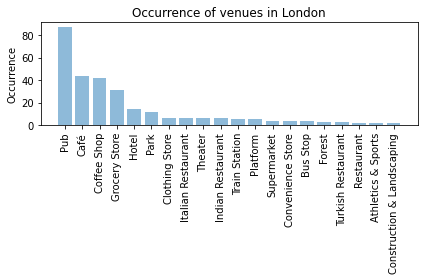

In [60]:
tmp = pd.DataFrame(london_neighborhoods_venues_sorted.groupby('1st Most Common Venue').count()['Neighborhood'])
tmp.rename(columns={'Neighborhood':'Occurrence'},inplace=True)
tmp = tmp.sort_values(by='Occurrence',ascending=False)
tmp = tmp[tmp['Occurrence'] > 1]

y = np.arange(len(tmp.index))

plt.bar(y, tmp['Occurrence'], align='center', alpha=0.5)
plt.xticks(y, tmp.index, rotation='vertical')
plt.ylabel('Occurrence')
plt.title('Occurrence of venues in London')
plt.tight_layout()
plt.savefig('Occurrence of venues in London.pdf')
plt.show()

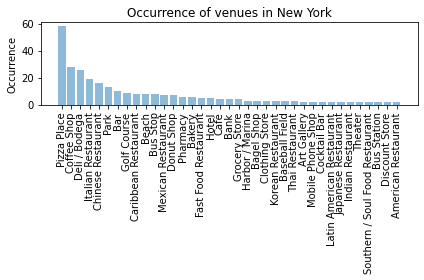

In [61]:
tmp = pd.DataFrame(newyork_neighborhoods_venues_sorted.groupby('1st Most Common Venue').count()['Neighborhood'])
tmp.rename(columns={'Neighborhood':'Occurrence'},inplace=True)
tmp = tmp.sort_values(by='Occurrence',ascending=False)
tmp = tmp[tmp['Occurrence'] > 1]

y = np.arange(len(tmp.index))

plt.bar(y, tmp['Occurrence'], align='center', alpha=0.5)
plt.xticks(y, tmp.index, rotation='vertical')
plt.ylabel('Occurrence')
plt.title('Occurrence of venues in New York')
plt.tight_layout()
plt.savefig('Occurrence of venues in New York.pdf')
plt.show()

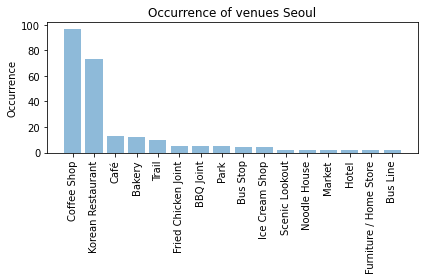

In [62]:
tmp = pd.DataFrame(seoul_neighborhoods_venues_sorted.groupby('1st Most Common Venue').count()['Neighborhood'])
tmp.rename(columns={'Neighborhood':'Occurrence'},inplace=True)
tmp = tmp.sort_values(by='Occurrence',ascending=False)
tmp = tmp[tmp['Occurrence'] > 1]

y = np.arange(len(tmp.index))

plt.bar(y, tmp['Occurrence'], align='center', alpha=0.5)
plt.xticks(y, tmp.index, rotation='vertical')
plt.ylabel('Occurrence')
plt.title('Occurrence of venues Seoul')
plt.tight_layout()
plt.savefig('Occurrence of venues in Seoul.pdf')
plt.show()

From these plots, we can already see difference between the cities. For example, the most common venue in London seems to be pubs while in New York it seems to be pizza places. Both have a large distance to the next common venue. These venues also fit to some extent what one would expect from those cities. Common for both are for example coffee shops, which are not generally attributed to a specific country. Seoul on the other hand has coffee shops as the most common venue, before a distinct venue, such as korean restaurants. This is surprising, but we need to be careful, as we only consider the most common venue of each neighborhood.

## Finding similarity and differences
### Clustering
Next, we will use clustering to put together neighborhoods that are similar. Then we will use common marker for those clusters to see what kind of neighborhoods they are and then compare the results of the different cities.

Let's first define the parameters and transform the data.

In [63]:
params = {'n_clusters':range(1,25)}
london_grouped_clustering = london_grouped.drop(['Neighborhood', 'Borough'], 1)
newyork_grouped_clustering = newyork_grouped.drop(['Neighborhood', 'Borough'], 1)
seoul_grouped_clustering = seoul_grouped.drop(['Neighborhood', 'Borough'], 1)
random_state=42

Next, we try out several values for k and use the elbow method as well as the silhouette method to estimate the optimal values for k.

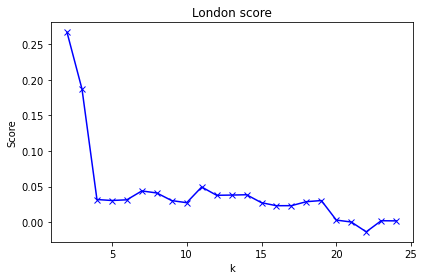

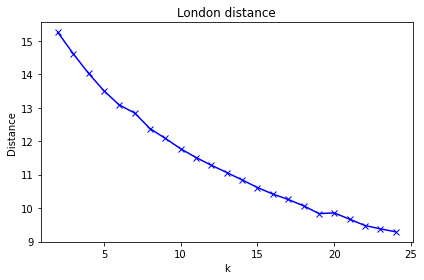

In [64]:
london_score = []
london_distance = []
K = range(2,25)
for k in K:
    km = KMeans(n_clusters=k,random_state=random_state).fit(london_grouped_clustering)
    labels = km.labels_
    london_score.append(silhouette_score(london_grouped_clustering, labels, metric='euclidean'))
    london_distance.append(km.inertia_)
plt.plot(K, london_score, 'bx-')
plt.xlabel('k')
plt.ylabel('Score')
plt.title('London score')
plt.tight_layout()
plt.savefig('london_score.pdf')
plt.show()
plt.plot(K, london_distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Distance')
plt.title('London distance')
plt.tight_layout()
plt.savefig('london_distance.pdf')
plt.show()
with open('london_score.csv','w') as f:
    for i in london_score:
        f.write(str(i) + '\n')
with open('london_distance.csv','w') as f:
    for i in london_distance:
        f.write(str(i) + '\n')

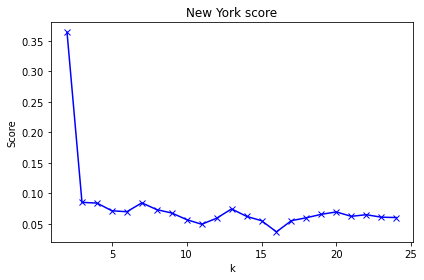

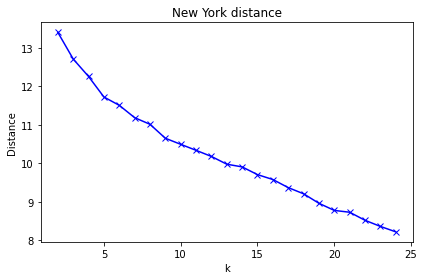

In [65]:
newyork_score = []
newyork_distance = []
K = range(2,25)
for k in K:
    km = KMeans(n_clusters=k,random_state=random_state).fit(newyork_grouped_clustering)
    labels = km.labels_
    newyork_score.append(silhouette_score(newyork_grouped_clustering, labels, metric='euclidean'))
    newyork_distance.append(km.inertia_)
plt.plot(K, newyork_score, 'bx-')
plt.xlabel('k')
plt.ylabel('Score')
plt.title('New York score')
plt.tight_layout()
plt.savefig('newyork_score.pdf')
plt.show()
plt.plot(K, newyork_distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Distance')
plt.title('New York distance')
plt.tight_layout()
plt.savefig('newyork_distance.pdf')
plt.show()
with open('newyork_score.csv','w') as f:
    for i in newyork_score:
        f.write(str(i) + '\n')
with open('newyork_distance.csv','w') as f:
    for i in newyork_distance:
        f.write(str(i) + '\n')

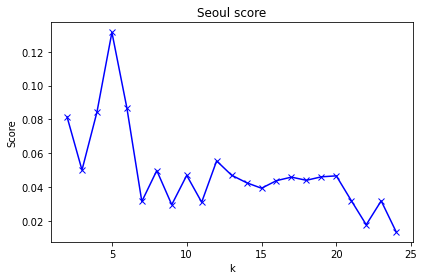

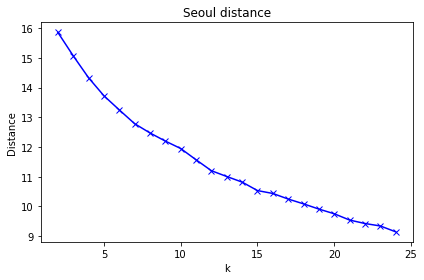

In [66]:
seoul_score = []
seoul_distance = []
K = range(2,25)
for k in K:
    km = KMeans(n_clusters=k,random_state=random_state).fit(seoul_grouped_clustering)
    labels = km.labels_
    seoul_score.append(silhouette_score(seoul_grouped_clustering, labels, metric='euclidean'))
    seoul_distance.append(km.inertia_)
plt.plot(K, seoul_score, 'bx-')
plt.xlabel('k')
plt.ylabel('Score')
plt.title('Seoul score')
plt.tight_layout()
plt.savefig('seoul_score.pdf')
plt.show()
plt.plot(K, seoul_distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Distance')
plt.title('Seoul distance')
plt.tight_layout()
plt.savefig('seoul_distance.pdf')
plt.show()
with open('seoul_score.csv','w') as f:
    for i in seoul_score:
        f.write(str(i) + '\n')
with open('seoul_distance.csv','w') as f:
    for i in seoul_distance:
        f.write(str(i) + '\n')

None of the methods can easily give as a value though. While for London and New York the silhouette gives us an optimal value of two, this value doesn't make much sense if we include domain knowledge. The most basic neighborhoods include residential, commercial, and industrial, which would already be more than two. The next best value is around seven, while for Seoul it is five. These values seem fine and more or less agree with the elbow method. For now, we chose seven for London and New York and five for Seoul.

In [67]:
k_london = 7
k_newyork = 7
k_seoul = 5
km_london = KMeans(n_clusters=k_london,random_state=random_state).fit(london_grouped_clustering)
km_newyork = KMeans(n_clusters=k_newyork,random_state=random_state).fit(newyork_grouped_clustering)
km_seoul = KMeans(n_clusters=k_seoul,random_state=random_state).fit(seoul_grouped_clustering)

First, we prepare the dataframes and add the cluster labels.

In [68]:
try:
    london_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', km_london.labels_)
except:
    print('Already included')
    pass
london_merged = df_london
london_merged = london_merged.join(london_neighborhoods_venues_sorted.set_index(['Neighborhood', 'Borough']), on=['Neighborhood', 'Borough'])
london_merged['Cluster Labels'] = london_merged['Cluster Labels'].astype('int')
london_merged

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Abbey Wood,"Bexley, Greenwich",51.485572,0.119687,2,Convenience Store,Coffee Shop,Campground,Grocery Store,Train Station,...,Filipino Restaurant,Event Space,Exhibit,Fabric Shop,Coworking Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
1,Acton,"Ealing, Hammersmith, Fulham",51.502729,-0.254255,5,Bakery,Indian Restaurant,Grocery Store,Chinese Restaurant,Warehouse Store,...,Coffee Shop,Playground,Diner,Gym / Fitness Center,Wine Shop,Bus Stop,Breakfast Spot,Fish & Chips Shop,Event Service,Food Court
2,Aldgate,City,51.514248,-0.075719,1,Hotel,Coffee Shop,Pub,Gym / Fitness Center,Cocktail Bar,...,French Restaurant,Salad Place,Castle,Scenic Lookout,Japanese Restaurant,English Restaurant,Turkish Restaurant,Pizza Place,Art Gallery,Arts & Crafts Store
3,Aldwych,Westminster,51.513103,-0.114920,1,Theater,Pub,Hotel,Coffee Shop,Restaurant,...,Scenic Lookout,French Restaurant,Wine Bar,Building,Hotel Bar,Gym,English Restaurant,Tea Room,Tapas Restaurant,Beer Bar
4,Anerley,Bromley,51.407599,-0.061939,5,Grocery Store,Train Station,Gastropub,Convenience Store,Tram Station,...,Fast Food Restaurant,Zoo Exhibit,Exhibit,Event Service,Event Space,Factory,Ethiopian Restaurant,Fabric Shop,Farmers Market,Falafel Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,Woodford,Redbridge,51.606806,0.034012,1,Metro Station,Coffee Shop,Hotel,Bakery,Grocery Store,...,Rental Car Location,Indian Restaurant,Italian Restaurant,Fish Market,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Factory
306,Woodford Green,"Redbridge, Waltham Forest",51.483494,-0.196802,2,Pub,Coffee Shop,Grocery Store,Café,Pizza Place,...,Sporting Goods Shop,Mediterranean Restaurant,Gastropub,Park,Warehouse Store,Lounge,Sandwich Place,Bistro,Supermarket,Garden
307,Woodside Park,Barnet,51.617948,-0.185579,1,Coffee Shop,Café,Bookstore,Pharmacy,Sushi Restaurant,...,Turkish Restaurant,Hotel,Ice Cream Shop,Discount Store,Supermarket,Breakfast Spot,Portuguese Restaurant,Gift Shop,Optical Shop,Tea Room
308,Woolwich,Greenwich,51.482670,0.062334,5,Chinese Restaurant,Supermarket,Middle Eastern Restaurant,Grocery Store,Bus Stop,...,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Film Studio,Filipino Restaurant,Ethiopian Restaurant,Fish Market,Flea Market


In the case of New York, we need to drop a row as this one does not have any venues (Port Ivory). 

In [69]:
try:
    newyork_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', km_newyork.labels_)
except:
    print('Already included')
    pass
newyork_merged = df_newyork
newyork_merged = newyork_merged.join(newyork_neighborhoods_venues_sorted.set_index(['Neighborhood', 'Borough']), on=['Neighborhood', 'Borough'])
newyork_merged.dropna(inplace=True)
newyork_merged['Cluster Labels'] = newyork_merged['Cluster Labels'].astype('int')
newyork_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Bronx,Melrose,40.825670,-73.915242,3,Donut Shop,Diner,Supermarket,Sandwich Place,Pharmacy,...,Mexican Restaurant,Pizza Place,Deli / Bodega,Gym,Bus Station,Supplement Shop,Martial Arts Dojo,Food Truck,Park,Sporting Goods Shop
1,Bronx,Mott Haven,40.808990,-73.922915,3,Pizza Place,Discount Store,Donut Shop,Grocery Store,Diner,...,Bar,Mobile Phone Shop,Supermarket,Nightclub,Steakhouse,Speakeasy,Fish & Chips Shop,Flower Shop,Bakery,Fast Food Restaurant
2,Bronx,Port Morris,40.801515,-73.909581,1,Furniture / Home Store,Gym,Baseball Field,Latin American Restaurant,Home Service,...,Music Venue,Performing Arts Venue,Brewery,Storage Facility,Cupcake Shop,Peruvian Restaurant,Food Truck,Restaurant,Falafel Restaurant,Farm
3,Bronx,Hunts Point,40.812601,-73.884025,1,Bakery,Plaza,Nightclub,Bus Stop,Spanish Restaurant,...,Chinese Restaurant,Bank,BBQ Joint,Coffee Shop,Shipping Store,Pizza Place,Juice Bar,Food Truck,Deli / Bodega,Restaurant
4,Bronx,Longwood,40.816292,-73.896220,3,Fast Food Restaurant,Discount Store,Grocery Store,Latin American Restaurant,Donut Shop,...,Theater,Chinese Restaurant,Gym,Mobile Phone Shop,Coffee Shop,Men's Store,Park,Pizza Place,Bowling Alley,Plaza
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,Staten Island,Prince's Bay,40.528994,-74.197644,3,Bank,Italian Restaurant,Pizza Place,Comfort Food Restaurant,Nail Salon,...,Bagel Shop,Train Station,Donut Shop,Liquor Store,Asian Restaurant,Sandwich Place,Sushi Restaurant,Ice Cream Shop,Print Shop,Deli / Bodega
326,Staten Island,Richmond Valley,40.520105,-74.229311,3,Bank,American Restaurant,Bakery,Pharmacy,Coffee Shop,...,Toll Plaza,Farmers Market,Train Station,Lounge,Pizza Place,Gym,Mexican Restaurant,Café,Convenience Store,Japanese Restaurant
327,Staten Island,Rossville,40.555624,-74.212898,3,Bagel Shop,Ice Cream Shop,Bus Stop,Food,Grocery Store,...,Dessert Shop,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop
328,Staten Island,Tottenville,40.511217,-74.249312,2,Italian Restaurant,Pizza Place,American Restaurant,Bagel Shop,Other Nightlife,...,Boat or Ferry,Deli / Bodega,Food Court,Field,Exhibit,Eye Doctor,Fried Chicken Joint,Factory,French Restaurant,Falafel Restaurant


In [70]:
try:
    seoul_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', km_seoul.labels_)
except:
    print('Already included')
    pass
seoul_merged = df_seoul
seoul_merged = seoul_merged.join(seoul_neighborhoods_venues_sorted.set_index(['Neighborhood', 'Borough']), on=['Neighborhood', 'Borough'])
seoul_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Dobong-gu,Dobong-dong,37.682606,127.042541,2,Korean Restaurant,Trail,Park,Metro Station,Café,...,Food Truck,Food Court,Food,Flower Shop,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,Cultural Center,Farm
1,Dobong-gu,Banghak-dong,37.664420,127.033330,4,Bakery,Fast Food Restaurant,Noodle House,Market,Park,...,Farm,Zoo,Electronics Store,Fish Market,Flea Market,Flower Shop,Food,Food Court,Food Truck,Forest
2,Dobong-gu,Ssangmun-dong,37.653470,127.027150,4,Park,Golf Course,Restaurant,Museum,Café,...,Fish Market,Fast Food Restaurant,Electronics Store,Flea Market,Flower Shop,Food,Food Court,Food Truck,Ethiopian Restaurant,Eastern European Restaurant
3,Dobong-gu,Chang-dong,37.652834,127.047896,1,Ice Cream Shop,Coffee Shop,Bakery,Supermarket,Bus Stop,...,BBQ Joint,Performing Arts Venue,Japanese Restaurant,Discount Store,Event Space,Food Truck,Food Court,Food,Flower Shop,Cupcake Shop
4,Dongdaemun-gu,Cheongnyangni-dong,37.578921,127.044977,4,Bus Stop,Department Store,Korean Restaurant,Noodle House,Market,...,Donut Shop,Bakery,BBQ Joint,Fast Food Restaurant,Park,Japanese Restaurant,Japanese Curry Restaurant,Electronics Store,Bookstore,Farmers Market
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,Jung-gu,Pil-dong,37.551247,126.988264,1,Scenic Lookout,Korean Restaurant,Café,Italian Restaurant,Coffee Shop,...,French Restaurant,Fried Chicken Joint,Breakfast Spot,Mountain,Market,Noodle House,Buffet,Shopping Plaza,Candy Store,Gift Shop
257,Jung-gu,Sindang-dong,37.556901,127.014920,2,Korean Restaurant,Bunsik Restaurant,Bakery,Coffee Shop,Café,...,Ice Cream Shop,Duty-free Shop,Donut Shop,Grocery Store,Bus Stop,Fast Food Restaurant,Stadium,Beer Bar,Chinese Restaurant,Tunnel
258,Jung-gu,Sindang 5-dong,37.565384,127.016252,1,Korean Restaurant,Coffee Shop,BBQ Joint,Bus Stop,Dessert Shop,...,Noodle House,Toy / Game Store,Museum,Art Museum,Bistro,Shopping Mall,Scenic Lookout,General Entertainment,Metro Station,Park
259,Jung-gu,Sogong-dong,37.564289,126.980010,1,Korean Restaurant,Hotel,Chinese Restaurant,Coffee Shop,Café,...,Dessert Shop,Souvenir Shop,Noodle House,Seafood Restaurant,Bossam/Jokbal Restaurant,Bistro,Theater,Tea Room,Hotel Bar,Italian Restaurant


Then we visualize the clusters on top of the maps.

In [71]:
address = 'London, London'
geolocator = Nominatim(user_agent="mult_loc")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_clusters_london = folium.Map(location=[latitude, longitude], zoom_start=11)
x = np.arange(k_london)
ys = [i + x + (i*x)**2 for i in range(k_london)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Neighborhood'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_london)
       
map_clusters_london

In [72]:
address = 'New York, New York'
geolocator = Nominatim(user_agent="mult_loc")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_clusters_newyork = folium.Map(location=[latitude, longitude], zoom_start=11)
x = np.arange(k_newyork)
ys = [i + x + (i*x)**2 for i in range(k_newyork)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged['Latitude'], newyork_merged['Longitude'], newyork_merged['Neighborhood'], newyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_newyork)
       
map_clusters_newyork

In [73]:
address = 'Seoul, Seoul'
geolocator = Nominatim(user_agent="mult_loc")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_clusters_seoul = folium.Map(location=[latitude, longitude], zoom_start=11)
x = np.arange(k_seoul)
ys = [i + x + (i*x)**2 for i in range(k_seoul)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(seoul_merged['Latitude'], seoul_merged['Longitude'], seoul_merged['Neighborhood'], seoul_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_seoul)
       
map_clusters_seoul

### Categorizing and scoring the different clusters
Now that we have each neighborhood in a cluster, we categorize each cluster according to their venues. For this purpose and also for finding possible differences or similarities, we rank each type of venue in the cluster. 

We first define a function that gets aggregates the occurrences of each venue and weights it according to the mean values we computed previously. We take the 25 most common venues and aggregate the rest under *Others*. Additionally, we save the size of the cluster as well.

In [74]:
def get_top_categories(grouped, df, max_categories):
    d = {}
    for ind in df.index:
        row = grouped.loc[(grouped[df.columns[1]] == df.at[ind,df.columns[1]]) & (grouped[df.columns[0]] == df.at[ind,df.columns[0]])]
        for col in df.columns[2:]:
            if df.at[ind,col] in d:
                d[df.at[ind,col]] += row[df.at[ind,col]].values
            else:            
                d[df.at[ind,col]] = row[df.at[ind,col]].values
    tmp = pd.DataFrame(d)
    row_categories = tmp.iloc[0,:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    tmp = pd.DataFrame(row_categories_sorted[0:max_categories])
    tmp.loc['Others',0] = row_categories_sorted[max_categories:].sum()
    tmp.loc['Size',0] = len(df.index)
    tmp.loc['Number of types',0] = row_categories_sorted.count()
    return tmp

Next, we use that function to rank venues in clusters for each city. We save the rankings for further processing and plot the most popular venues for each cluster. Based on that, we try to categorize them into specific types.

The first cluster of London has as its most common venues parks, followed by Cafes, and pubs. This hints at neighborhoods with high recreational value, but the high occurrence of grocery stores hints more at residential areas. We can cross check with the map above, and indeed the neighborhoods are more outside of the city. We will categorize it as recreational/residential.
The second cluster has a high amount of coffee shops, pubs, and cafes, shortly followed by hotels. This cluster seems to describe a touristic area, but not necessarily for sightseeing. If we compare it with the map above, it includes the entire city center. We will categorize it as tourist residence/city center.
The third cluster is not entirely clear, it consists mostly of pubs, cafes, coffee shops, and other restaurants, but it also contains grocery stores and supermarkets. This seems partially residential combined with a high amount of entertainment. The location of the neighborhood, outside of the city center enforce that category.
The fourth cluster is a very small one that is hard to categorize. It has English restaurants, a train station, but also a golf course. It is possible that this is an older residential area or a more wealthy one. It also lies fairly far away from the city center.
The main venue of the fifth one are platforms, which are basically the stations for the tram. These neighborhoods also lie outside of the city center ans has parks and pubs. This is very likely a pure residential area.
The sixth cluster has a very high amount of grocery stores and seems to be residential areas more outside the city.
The seventh cluster is again very small and consists of two neighborhoods beside each other. The main defining venue are golf courses, which likely define the whole neighborhood and fit into a recreational area.

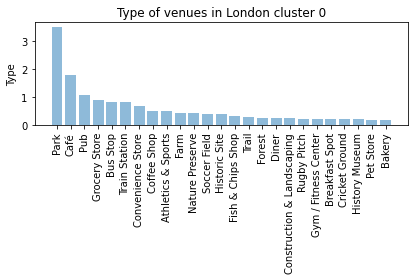

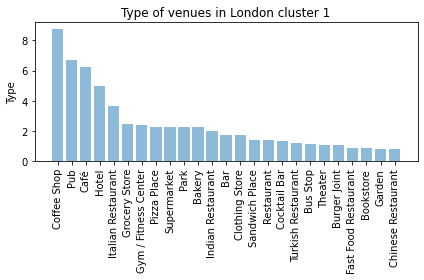

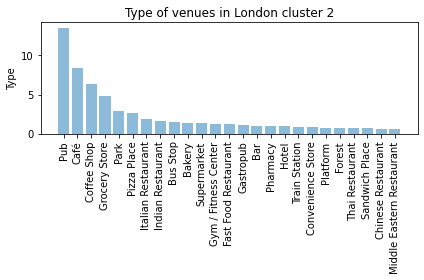

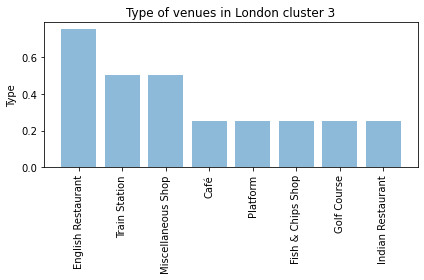

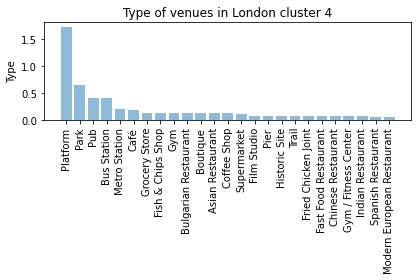

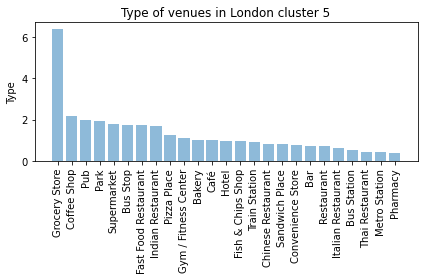

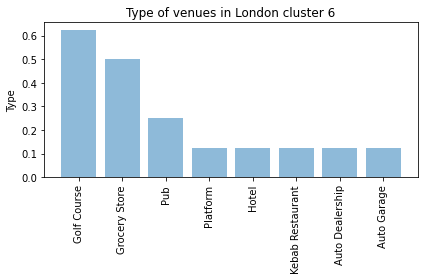

In [75]:
for i in range(k_london):
    df = london_merged.loc[london_merged['Cluster Labels'] == i, list(london_merged.columns[:2]) + list(london_merged.columns[5:])]
    ranking = get_top_categories(london_grouped, df, 25)
    ranking.to_csv('London ranking cluster ' + str(i) + '.csv')
    x = ranking[:-3]
    x = x[x[0] > 0.0][0].to_list()
    y_label = ranking[:-3]
    y_label = y_label[y_label[0] > 0.0].index
    y = np.arange(len(y_label))

    plt.bar(y, x, align='center', alpha=0.5)
    plt.xticks(y, y_label, rotation='vertical')
    plt.ylabel('Type')
    plt.title('Type of venues in London cluster ' + str(i))
    plt.tight_layout()
    plt.savefig('Type of venues in London cluster ' + str(i) + '.pdf')
    plt.show()

The first cluster of New York is dominated by Delis and Bodegas, which prepare food or are mostly grocery stores. While there are other venues, such as bus stops, parks, or pharmacies present as well, the large majority is food preparation in this cluster. Therefore, we categorize it is recreational/residential/food area. These areas are also not part of the city center.
The second cluster is a mix of places, ranging from coffee shops, to pizza places, bars, parks, and so on. Combined with the map above, we can see that this encompasses the city center, especially most of Manhatten. A large difference with the London city center is the relative absence of hotels in this area.
The third cluster is dominated by Italien restaurants and lies mostly at the edge of the city. These seem Italian dominated neighborhoods.
While the fourth cluster is dominated by pizza places, at the fourth position are banks. These neighborhoods stretch over a large part of New York and seem mostly resididential areas. It is not clear why there are so many banks though.
The fifth cluster is very small and seems to be composed of pure recreational areas.
The sixth cluster encompases all beaches and the surrounding neighborhoods and seem mostly recreational.
Similar, the seventh cluster seems recreational as well with golf courses, the harbour, and other activities. Notably, it is small, but also contains tourist information.

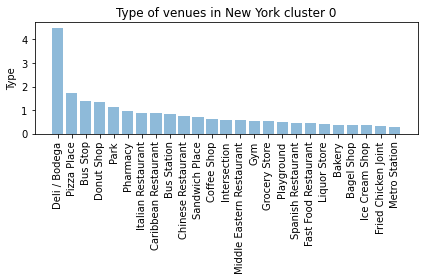

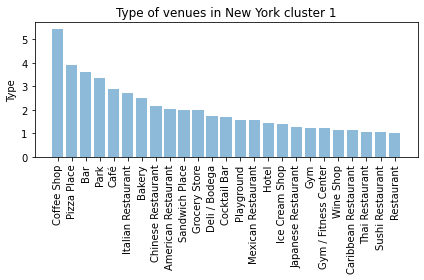

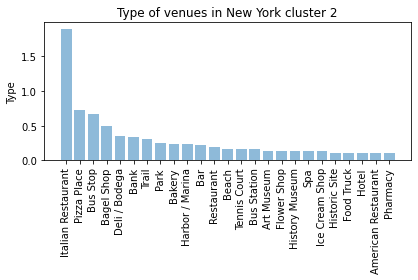

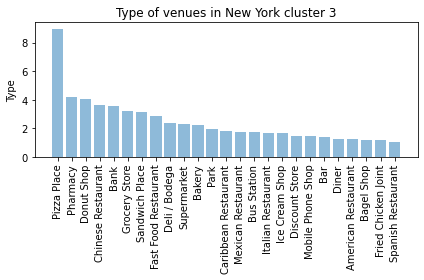

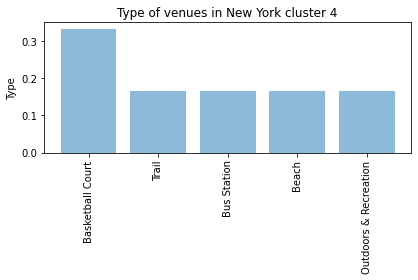

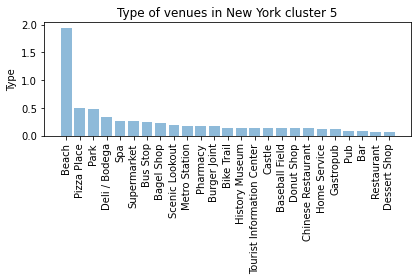

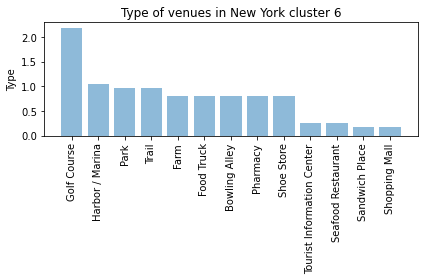

In [76]:
for i in range(k_newyork):
    df = newyork_merged.loc[newyork_merged['Cluster Labels'] == i, list(newyork_merged.columns[:2]) + list(newyork_merged.columns[5:])]
    ranking = get_top_categories(newyork_grouped, df, 25)
    ranking.to_csv('New York ranking cluster ' + str(i) + '.csv')
    x = ranking[:-3]
    x = x[x[0] > 0.0][0].to_list()
    y_label = ranking[:-3]
    y_label = y_label[y_label[0] > 0.0].index
    y = np.arange(len(y_label))

    plt.bar(y, x, align='center', alpha=0.5)
    plt.xticks(y, y_label, rotation='vertical')
    plt.ylabel('Type')
    plt.title('Type of venues in New York cluster ' + str(i))
    plt.tight_layout()
    plt.savefig('Type of venues in New York cluster ' + str(i) + '.pdf')
    plt.show()

The first cluster of Seoul is mainly dominated by coffee shops. These neighborhoods are mostly at the edge of the city and also contain other culinary venues, but also some entertainment. These neighborhoods seem more residential and social.
The second cluster composes most of the city center. The most common venue are again coffee shops, but a significant amount of restaurants are resent as well, of which many offer local food. While partially similar to the city center of New York, presence of many hotels also shows similarities with London.
The third cluster is completely dominated by Korean restaurants. It covers part of the city center, but neighborhoods can also be found outside. It is likely that many of these restaurants are similar to Delis in New York, which prepare and sell food to go.
The fourth cluster is the smallest and consists of one neighborhood. There is no clear categorization possible as it has a furniture shop, a cafe, and a tea room. Additionally, it is close to the airport.
The fifth cluster is dominated by bakeries and parks, but also additional restaurants. These areas seem more residential and recreational.

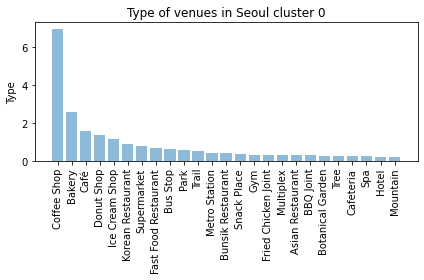

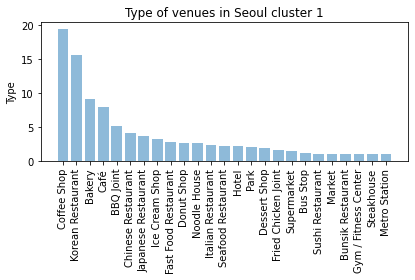

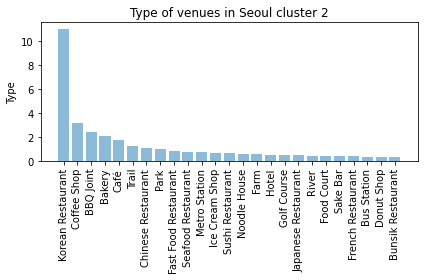

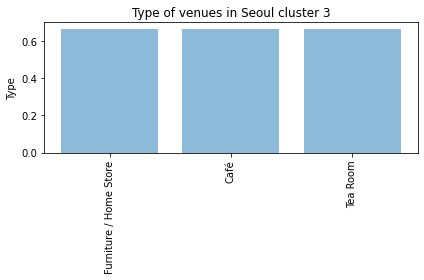

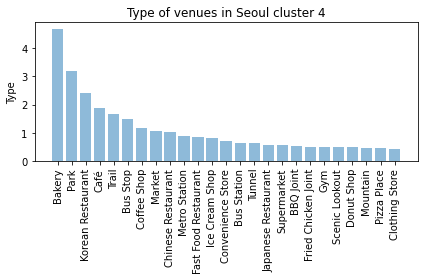

In [77]:
for i in range(k_seoul):
    df = seoul_merged.loc[seoul_merged['Cluster Labels'] == i, list(seoul_merged.columns[:2]) + list(seoul_merged.columns[5:])]
    ranking = get_top_categories(seoul_grouped, df, 25)
    ranking.to_csv('Seoul ranking cluster ' + str(i) + '.csv')
    x = ranking[:-3]
    x = x[x[0] > 0.0][0].to_list()
    y_label = ranking[:-3]
    y_label = y_label[y_label[0] > 0.0].index
    y = np.arange(len(y_label))

    plt.bar(y, x, align='center', alpha=0.5)
    plt.xticks(y, y_label, rotation='vertical')
    plt.ylabel('Type')
    plt.title('Type of venues in Seoul cluster ' + str(i))
    plt.tight_layout()
    plt.savefig('Type of venues in Seoul cluster ' + str(i) + '.pdf')
    plt.show()